<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png", width=500></p>

<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

---

<h2 style="text-align: center;"><b>Object detection</b></h2>

### Руководители проекта: 
* Илья Захаркин (Samsung AI Center - Moscow) | tg:@izakharkin
* Юрий Яровиков (AIRI, МФТИ) | tg:@yu_rovikov

<p style="text-align: center;"><img src="https://miro.medium.com/max/750/1*LTPAzUjUentTWoXXmqoT9g.jpeg"></p>

<h2 style="text-align: center;"><b>Этапы работы</b></h2>

Проект подразумевает выполнение всеми участниками пунктов 1-2, и далее выбор каждым слушателем своего сценария -- 1 или 2. Можно сделать оба сценария, то есть обучить модель на своих данных и её же встроить в демо, но для этого стоит быть готовым к удвоению затрачиваемого на проект времени.

<h3 style="text-align: center;"><b>Общий этап работы</b></h3>

**Hint**: если у вас на компьютере нет GPU, то лучше с самого начала делать все в Google Colab.

**1). Выбор фреймворка/библиотеки для использования детектора**

Чтобы освежить память о задаче детекции, можно посмотреть [занятия на продвинутом курсе](https://stepik.org/lesson/458312/step/1?unit=616130).

В выборе фреймворка предоставляется свобода, лично я рекомендовал бы один из:
- `torchvision.models.detection` и `torchhub`: "нативные" модели для детектирования прямо из PyTorch. Примеры использования есть прямо на занятиях DLSchool по практике CV [2019 года](https://www.youtube.com/watch?v=XSPYe4-y4HE) и [2020 года](https://stepik.org/lesson/458313/step/1?unit=616131);
- `mmdetection`: как с ним работать, рассказывается в [практическом занятии](https://stepik.org/lesson/458313/step/2?unit=616131).
- `detectron2`: краткая информация есть в конце [занятия DLSchool по практике CV](https://www.youtube.com/watch?v=XSPYe4-y4HE), можно начать с него. Лучше самостоятелньо изучить [официальный репозиторий](https://github.com/facebookresearch/detectron2) и уже с ним работать в дальнейшем ("Quick Start");
- `TensorFlow Object Detection API`: как с ним работать рассказывается в [занятии 2018 года](https://www.youtube.com/watch?v=xHIzyrU1uVM). Работать предстоит с [официальным репозиторием](https://github.com/tensorflow/models/tree/master/research/object_detection).

Рекомендую выбрать один из них и работать уже с этим модулем.

> Результатом пункта является зафиксированный фреймворк для нейросети-детектора.

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

import json
import torch
import torchvision.transforms.functional as FT
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image, ImageDraw, ImageFont
import math
from itertools import product as product
import torchvision
import torch.optim
import torch.utils.data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import albumentations as A
from tqdm.notebook import tqdm
import re
import warnings
warnings.filterwarnings('ignore')

print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True


Возьмем в качестве модели для обучения RetinaNet

In [2]:
model = torchvision.models.detection.retinanet_resnet50_fpn(pretrained=True)
model.eval()

RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256, eps=0.0)


**2). Запуск детектора на случайных изображениях**

Этот пункт просто про то, чтобы запустить любую модель детектирования в выбранном выше репозитории. Таким образом, часть с запуском будет работать, и далее уже можно приступать к основным сценариям.

In [3]:
transforms_ = transforms.ToTensor() 
img = Image.open("cars.jpg")
transformed_image = transforms_(img)
batched = transformed_image.unsqueeze(0)
int_img = torch.tensor(transformed_image * 255, dtype=torch.uint8)

In [4]:
with torch.no_grad():
    out = model(batched)

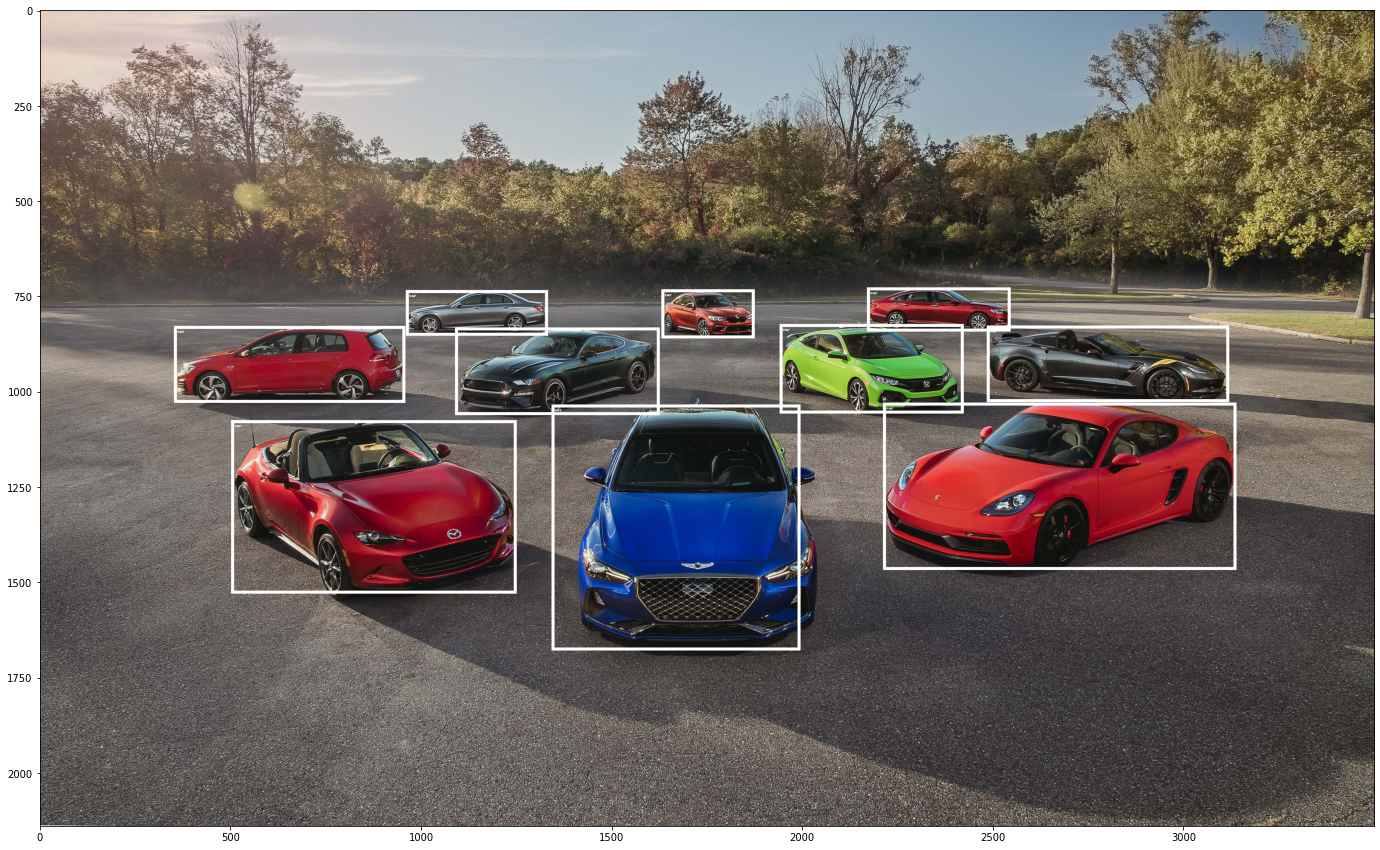

In [5]:
from torchvision.utils import draw_bounding_boxes
score_threshold = .7
first_out = out[0]
boxes=first_out['boxes'][first_out['scores'] > score_threshold].to('cpu')
labels=['car' for label in (first_out['labels'][first_out['scores'] > score_threshold])]
bounding_boxes_img = draw_bounding_boxes(int_img, boxes, labels=labels, width=8, font_size=15)
plt.figure(figsize=(25, 15))
plt.imshow(bounding_boxes_img.permute(1, 2, 0)) # convert image to matplotlib compatible
plt.show()

In [6]:
img = torchvision.transforms.ToPILImage()(bounding_boxes_img)
img.save("cars_bounded.jpg")

По каким-то неизвестным мне причинам размер шрифта не увеличивается, однако если посмотреть на сохрененное изображение, можно заметить, что лейблы приписались

> Результатом пункта явлется набор изображений, на которых модель успешно отработала и результат детекции виден и понятен.

<h3 style="text-align: center;"><b>2 сценарий</b></h3>

Во втором сценарии упор делается на сбор выборки, преобработку данных, обучение модели и измерение качества её работы. То есть осуществляется полный цикл разработки нейросетевой модели для задачи детектирования без встривания в веб/мобильный прототип.

**3). Выбор датасета**

При работе с датасетом вы неизбежно столкнетесь с работой с файлами и папками (директориями). Рекомендуется освежить в памяти работу с библиотеками `os`, `json`, `glob`. Может помочь [этот туториал](https://realpython.com/working-with-files-in-python/).

На выбор предоставляются 5 датасетов по детекции объектов:
1. [Детекция игровых карт](https://github.com/EdjeElectronics/TensorFlow-Object-Detection-API-Tutorial-Train-Multiple-Objects-Windows-10): лежат в папке images вместе с разметкой;
2. [Детекция фруктов](https://www.kaggle.com/mbkinaci/fruit-images-for-object-detection): скачать можно, нажав на кнопку Download;
3. [Детекция одежды (Deep Fashion 2)](https://github.com/switchablenorms/DeepFashion2): стоит прочитать README на главной странице репозитория. Для получения датасета нужно запросить пароль у автора через гугл-форму. После скачивания распакуйте его с использованием пароля. Из файлов аннотаций нас будут интересовать только `bounding_box`, `category_name` и `category_id`;
4. [Детекция лиц (Wider Face)](http://shuoyang1213.me/WIDERFACE/): большой датасет для детектирования лиц самых разных размеров. Скачать можно прямо по ссылкам на сайте;
5. [Детекция лиц (Kaggle)](https://www.kaggle.com/dataturks/face-detection-in-images): в датасете достаточно мало данных, но можно попробовать, если датасеты выше показались неподходящими для Вас;
6. Датасет из любого соревновани по детекции на Kaggle.

Выберем датасет фруктов.

Скачали и распаковали архив, вытащили папочки в более удобное место, теперь немножко предобработаем (прочитаем) входные данные

In [7]:
def spliter(line):
    line = re.split(">", line)
    line = re.split("<", line[1])
    return(line[0])


def create_dataframe(data_dir):
    image_boxes_list, image_id_list = [], []
    labels = set()
    for filename in os.listdir(data_dir):
        if filename.endswith(".xml"):
            f = open(data_dir + filename, 'r')
            image_boxes = []
            for element in f:
                if "<name>" in element:
                    image_boxes.append(spliter(element))
                    labels.add(spliter(element))
                if "<xmin>" in element:
                    image_boxes.append(int(spliter(element)))
                if "<ymin>" in element:
                    image_boxes.append(int(spliter(element)))
                if "<xmax>" in element:
                    image_boxes.append(int(spliter(element)))
                if "<ymax>" in element:
                    image_boxes.append(int(spliter(element)))
            image_id_list.append(filename.split('.')[0])
            image_boxes_list.append(image_boxes)
            
    df = pd.DataFrame(list(zip(image_id_list, image_boxes_list)),columns =['ImageId', 'ImageBoxes'])
    return df, labels

In [8]:
train_data, train_labels = create_dataframe("train/")
test_data, test_labels = create_dataframe("test/")

In [9]:
train_data

,ImageId,ImageBoxes
0,orange_14,"[orange, 23, 33, 272, 265]"
1,orange_73,"[orange, 191, 43, 853, 746]"
2,apple_49,"[apple, 15, 87, 255, 291]"
3,orange_12,"[orange, 159, 45, 520, 336]"
4,orange_15,"[orange, 155, 99, 411, 329, orange, 24, 1, 239..."
...,...,...
235,apple_50,"[apple, 147, 45, 288, 202, apple, 46, 40, 148,..."
236,banana_36,"[banana, 74, 58, 497, 387]"
237,mixed_8,"[orange, 141, 155, 499, 513, banana, 77, 133, ..."
238,banana_34,"[banana, 63, 48, 273, 310]"


In [10]:
train_labels, test_labels

({'apple', 'banana', 'orange'}, {'apple', 'banana', 'orange'})

In [11]:
labelmap = {"background": 0, "banana": 1, "orange": 2, "apple": 3}
rev_labelmap = {0: "background", 1: "banana", 2: "orange", 3: "apple"}

In [12]:
def tlbr_to_cchw(coordinates, w, h):
    res = [(coordinates[0] + coordinates[2]) / 2 / w,
           (coordinates[1] + coordinates[3]) / 2 / h,
           (coordinates[2] - coordinates[0]) / w,
           (coordinates[3] - coordinates[1]) / h]
    return res

def cchw_to_tlbr(coordinates, w, h):
    res = [(coordinates[0] - coordinates[2] / 2) * w,
           (coordinates[1] - coordinates[3] / 2) * h,
           (coordinates[0] + coordinates[2] / 2) * w,
           (coordinates[1] + coordinates[3] / 2) * h]
    return res

def prepare_data(df, folder = "train/"):
    images = []
    boxes = dict()
    for name, labels in tqdm(df.values):
        w, h = Image.open(folder + name + '.jpg').size
        image_boxes = {"labels": [],
                       "boxes": []}
        for i in range(len(labels) // 5):
            image_boxes["labels"].append(labelmap[labels[i * 5]])
            image_boxes["boxes"].append(labels[i * 5 + 1: i * 5 + 5])
        
        images.append(folder + name + '.jpg')
        boxes[folder + name + '.jpg'] = image_boxes
    return images, boxes

In [13]:
train_images, train_boxes = prepare_data(train_data)
test_images, test_boxes = prepare_data(test_data, 'test/')

> Результатом выполнения пункта явлется загруженный датасет, состоящий из изображений и разметки к ним (bounding box'ов всех объектов на каждом изображении).

**4). Предобработка данных**

Самый непростой этап в этом сценарии. Скачать данные $-$ лишь половина дела. Чтобы обучить нейросеть на этих данных, нужно написать генератор батчей. Однако если будем подавать изображения так, как они есть, то даже батч собрать не сможем -- нужно привести их к однмоу размеру. Далее нужно привести их к типу float, переместить на CUDA и поделить значения в пикселях на 255 (подробнее см. [занятие](https://www.youtube.com/watch?v=XSPYe4-y4HE)). Также нужно настроить аугментации и постобработку.

То, как именно все это реализовать $-$ зависит от инструмента, выбранного в пункте 1. Например, в detectron2 в обучающих материалах описан формат данных для обучения. Возможно, нужно будет зайти в документацию и почитать более подробно, чтобы разобраться, какой именно нужен формат координат.

НЕ нужно копировать все файлы с картинками и разметкой прямо на диске в их предобработанные версии. Хороший тон $-$ осуществлять всю эту обработку программно, "на лету". Поможет [туториал](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) по написанию своего датасета на PyTorch.

> Результатом выполнения пункта явлется код, запуск которого ведет к подаче батчей правильного вида (разметка приведена к требуемому формату координат, изображения нужного типа, размера и поделены на 255 и т.д.) для обучения нейронной сети-детектора.

In [14]:
class FruitsDataSet(Dataset):
    def __init__(self, images, targets):
        self.images = images
        self.targets = targets
        self.transform_A = A.Compose([
                    A.HorizontalFlip(p=0.5),
                    A.Rotate(p=0.5),
                ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))
 
    def __len__(self):
        return len(self.images)
 
    def getitem_notransform(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_name = self.images[idx]
        image = Image.open(img_name).convert('RGB')
        image = np.array(image)
        target = self.targets[img_name]
        sample = [image, target]
        return sample
 
    def __getitem__(self, idx):
        image, target = self.getitem_notransform(idx)
        transformed = self.transform_A(image=image, bboxes=target['boxes'], class_labels=target['labels'])
        image = transformed['image']
        target['boxes'] = transformed['bboxes']
        target['labels']  = transformed['class_labels']
        image = FT.to_tensor(image)
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        image = FT.normalize(image, mean=mean, std=std)
        target['boxes'] = torch.tensor(target['boxes'])
        target['labels'] = torch.tensor(target['labels'], dtype = torch.long)
        return image, target

batch_size = 10
datasets = {
    "train": FruitsDataSet(train_images, train_boxes),
    "test": FruitsDataSet(test_images, test_boxes),
}

def collate_fn(batch):
    return tuple(zip(*batch))
 
dataloaders = {
    "train": DataLoader(
        dataset=datasets["train"],
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        collate_fn=collate_fn,
    ),
    "test": DataLoader(
        dataset=datasets["test"],
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        collate_fn=collate_fn,
    ),
}

**5). Обучение модели-детектора** 

Стоит написать цикл обучения на PyTorch самостоятельно, однако допускается использовать [Catalyst](https://github.com/catalyst-team/catalyst), [PyTorch Lightning](https://github.com/williamFalcon/pytorch-lightning) или [Ignite](https://github.com/pytorch/ignite). Например, саму модель можно взять из фреймворка из пункта 1, а обучение осуществлять с помощью одной перечисленных трех библиотек.

In [15]:
from IPython.display import clear_output
import gc

def saving(epoch, model, optimizer, pth = 'checkpointNew.pth.tar'):
    torch.save({'epoch' : epoch,
            'model': model,
            'optimizer': optimizer,
            }, pth)
    
def train(train_loader, test_loader, model, optimizer, start_epoch, last_epoch, train_losses=[], test_losses=[]):
    model.to(device)
    model.train()  
    # Batches
    for num_epoch in tqdm(range(start_epoch, last_epoch)):
        clear_output(wait=True)
        
        print("Epoch ", num_epoch, "/", last_epoch)
        plt.figure(figsize=(16,9))   
        
        plt.plot(train_losses, label='Train loss')
        plt.plot(test_losses, label='Test loss')

        plt.legend()
        plt.show()
        
        epoch_loss = 0
        test_loss = 0
        for images, targets in tqdm(train_loader):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            loss_dict = model(images, targets)                

            losses = sum(loss for loss in loss_dict.values())

            optimizer.zero_grad()
            losses.backward()

            optimizer.step()
            torch.cuda.empty_cache()
            epoch_loss += losses
            
            del images, targets, loss_dict
            gc.collect()
            torch.cuda.empty_cache()
        
        with torch.no_grad():
            for images, targets in tqdm(test_loader):
                images = list(image.to(device) for image in images)
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

                loss_dict = model(images, targets)                

                losses = sum(loss for loss in loss_dict.values())

                test_loss += losses
                
                del images, targets, loss_dict
                gc.collect()
                torch.cuda.empty_cache()
        
        saving(num_epoch, model, optimizer)
        epoch_loss.to('cpu')
        test_loss.to('cpu')
        train_losses.append(epoch_loss.item() / 240)
        test_losses.append(test_loss.item() / 60)
        
    clear_output(wait=True)
    print("Train finished")
    plt.figure(figsize=(16,9))   

    plt.plot(train_losses, label='Train loss')
    plt.plot(test_losses, label='Test loss')

    plt.legend()
    plt.show()

In [16]:
learning_rate = 0.001
num_epoch = 100
momentum = 0.9
weight_decay = 0.00001

In [17]:
model = None
optimizer = None
checkpoint_path = "checkpointNew.pth.tar"
if checkpoint_path == None:
    model = torchvision.models.detection.retinanet_resnet50_fpn(num_classes=4)
    for param in model.backbone.parameters():
        param.requires_grad = False
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=learning_rate,
                                momentum=momentum, weight_decay=weight_decay)
else:
    checkpoint = torch.load(checkpoint_path)
    last_epoch = checkpoint['epoch']
    model = checkpoint['model']
    optimizer = checkpoint['optimizer']

Из-за перезапуска график не сохранился, поэтому вот выведем первую его часть

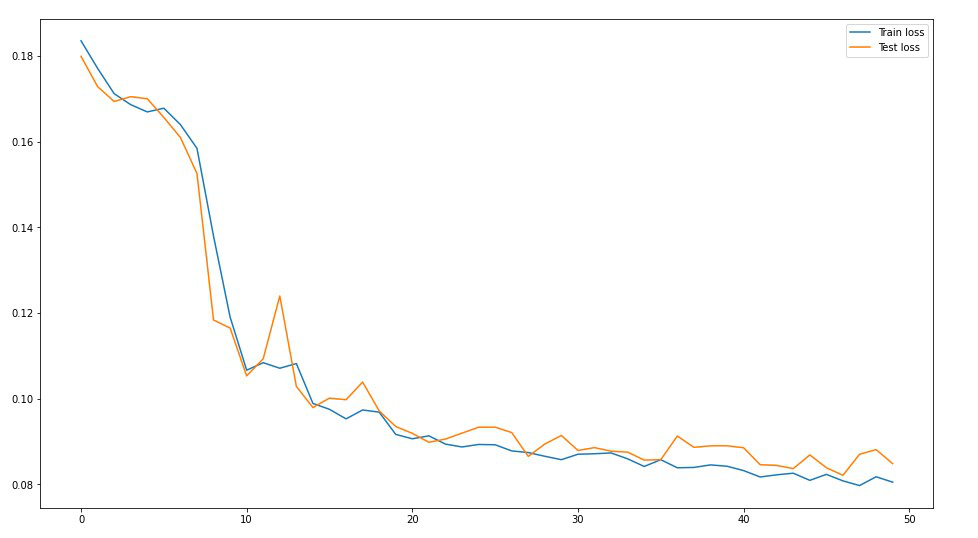

In [18]:
Image.open("first_50_epochs.jpg")

Train finished


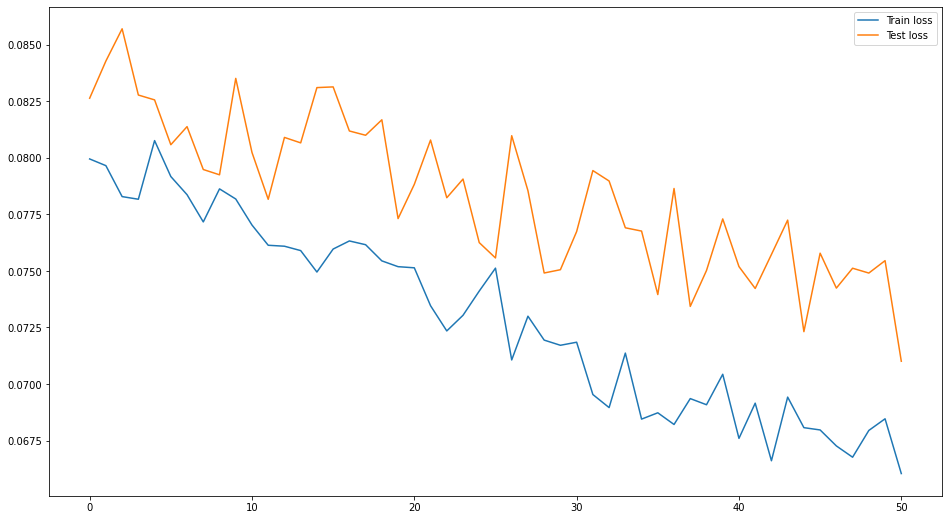

In [19]:
train(dataloaders['train'], dataloaders['test'], model, optimizer, last_epoch, num_epoch)

> Результатом выполнения пункта явлется код, запуск которого ведет к обучению модели на выбранном датасете. При обучении **обязательно выводить числовые значения лосса на трейне и валидации**, крайне желательно использовать [`TensorBoard`](https://pytorch.org/docs/stable/tensorboard.html) для визуализации. Обязательно также сохранять модель после каждой N-ой эпохи, чтобы потом ее качество можно было проверить и веса были переиспользуемыми.

**6). Измерение качества работы модели (метрики согласуются с руководителем и зависят от задачи)**

Под метриками понимаются функции/формулы, по которым оценивается качество модели-детектора. Обычно для измерения качества работы детектора используют поклассовые Precision, Recall, F1-меру и mean Average Precision (mAP). Подробнее про них можно послушать в [видеолекции 2018 года](https://www.youtube.com/watch?v=ewkSI2cuyoQ&list=PL0Ks75aof3ThkitsZbUOEQg7Ybl5kB_s3&index=24).

Необходимо самостоятельно реализовать функции, вычисляющие поклассовые Precision и Recall. На вход функциям поступают веса модели и выборка, на которой нужно измерить метрики. На выходе $-$ таблица с precision и recall для каждого класса.

> Результат пункта $-$ реализованные функции метрик для задачи детектирования, позволяющие оценить качество работы модели на выборке. Выборка/даталоадер является аргументом функций.

In [20]:
def find_intersection(set_1, set_2):
    """
    Find the intersection of every box combination between two sets of boxes that are in boundary coordinates.
    :param set_1: set 1, a tensor of dimensions (n1, 4)
    :param set_2: set 2, a tensor of dimensions (n2, 4)
    :return: intersection of each of the boxes in set 1 with respect to each of the boxes in set 2, a tensor of dimensions (n1, n2)
    """

    # PyTorch auto-broadcasts singleton dimensions
    lower_bounds = torch.max(set_1[:, :2].unsqueeze(1), set_2[:, :2].unsqueeze(0))  # (n1, n2, 2)
    upper_bounds = torch.min(set_1[:, 2:].unsqueeze(1), set_2[:, 2:].unsqueeze(0))  # (n1, n2, 2)
    intersection_dims = torch.clamp(upper_bounds - lower_bounds, min=0)  # (n1, n2, 2)
    return intersection_dims[:, :, 0] * intersection_dims[:, :, 1]  # (n1, n2)


def find_jaccard_overlap(set_1, set_2):
    """
    Find the Jaccard Overlap (IoU) of every box combination between two sets of boxes that are in boundary coordinates.
    :param set_1: set 1, a tensor of dimensions (n1, 4)
    :param set_2: set 2, a tensor of dimensions (n2, 4)
    :return: Jaccard Overlap of each of the boxes in set 1 with respect to each of the boxes in set 2, a tensor of dimensions (n1, n2)
    """

    # Find intersections
    intersection = find_intersection(set_1, set_2)  # (n1, n2)

    # Find areas of each box in both sets
    areas_set_1 = (set_1[:, 2] - set_1[:, 0]) * (set_1[:, 3] - set_1[:, 1])  # (n1)
    areas_set_2 = (set_2[:, 2] - set_2[:, 0]) * (set_2[:, 3] - set_2[:, 1])  # (n2)

    # Find the union
    # PyTorch auto-broadcasts singleton dimensions
    union = areas_set_1.unsqueeze(1) + areas_set_2.unsqueeze(0) - intersection  # (n1, n2)

    return intersection / union  # (n1, n2)

def calculate_mAP(det_boxes, det_labels, det_scores, true_boxes, true_labels):
    n_classes = len(labelmap)

    true_images = []
    for i in range(len(true_labels)):
        true_images.extend([i] * true_labels[i].size(0))
    true_images = torch.LongTensor(true_images).to(device)
    true_boxes = torch.cat(true_boxes, dim=0)
    true_labels = torch.cat(true_labels, dim=0)

    assert true_images.size(0) == true_boxes.size(0) == true_labels.size(0)

    det_images = list()
    for i in range(len(det_labels)):
        det_images.extend([i] * det_labels[i].size(0))
    det_images = torch.LongTensor(det_images).to(device)
    det_boxes = torch.cat(det_boxes, dim=0)
    det_labels = torch.cat(det_labels, dim=0)
    det_scores = torch.cat(det_scores, dim=0)

    assert det_images.size(0) == det_boxes.size(0) == det_labels.size(0) == det_scores.size(0)

    average_precisions = torch.zeros((n_classes - 1), dtype=torch.float) 
    for c in range(1, n_classes):
        true_class_images = true_images[true_labels == c]
        true_class_boxes = true_boxes[true_labels == c]

        true_class_boxes_detected = torch.zeros((true_class_images.size(0)), dtype=torch.uint8).to(
            device)

        det_class_images = det_images[det_labels == c]
        det_class_boxes = det_boxes[det_labels == c]
        det_class_scores = det_scores[det_labels == c]
        n_class_detections = det_class_boxes.size(0)
        if n_class_detections == 0:
            continue

        det_class_scores, sort_ind = torch.sort(det_class_scores, dim=0, descending=True)
        det_class_images = det_class_images[sort_ind]
        det_class_boxes = det_class_boxes[sort_ind]

        true_positives = torch.zeros((n_class_detections), dtype=torch.float).to(device)
        false_positives = torch.zeros((n_class_detections), dtype=torch.float).to(device)
        for d in range(n_class_detections):
            this_detection_box = det_class_boxes[d].unsqueeze(0)
            this_image = det_class_images[d]

            object_boxes = true_class_boxes[true_class_images == this_image]
            if object_boxes.size(0) == 0:
                false_positives[d] = 1
                continue

            overlaps = find_jaccard_overlap(this_detection_box, object_boxes)
            max_overlap, ind = torch.max(overlaps.squeeze(0), dim=0)  

            original_ind = torch.LongTensor(range(true_class_boxes.size(0)))[true_class_images == this_image][ind]

            if max_overlap.item() > 0.5:
                if true_class_boxes_detected[original_ind] == 0:
                    true_positives[d] = 1
                    true_class_boxes_detected[original_ind] = 1
                else:
                    false_positives[d] = 1
            else:
                false_positives[d] = 1

        cumul_true_positives = torch.cumsum(true_positives, dim=0)
        cumul_false_positives = torch.cumsum(false_positives, dim=0)
        cumul_precision = cumul_true_positives / (
                cumul_true_positives + cumul_false_positives + 1e-10)
        cumul_recall = cumul_true_positives / true_class_images.size(0)

        recall_thresholds = torch.arange(start=0, end=1.1, step=.1).tolist()  # (11)
        precisions = torch.zeros((len(recall_thresholds)), dtype=torch.float).to(device)  # (11)
        for i, t in enumerate(recall_thresholds):
            recalls_above_t = cumul_recall >= t
            if recalls_above_t.any():
                precisions[i] = cumul_precision[recalls_above_t].max()
            else:
                precisions[i] = 0.
        average_precisions[c - 1] = precisions.mean()
        
    mean_average_precision = average_precisions.mean().item()

    average_precisions = {rev_labelmap[c + 1]: v for c, v in enumerate(average_precisions.tolist())}

    return average_precisions, mean_average_precision

In [21]:
gc.collect()
torch.cuda.empty_cache()

In [22]:
from pprint import PrettyPrinter
pp = PrettyPrinter()

det_boxes = []
det_labels = []
det_scores = []
true_boxes = []
true_labels = []

model.eval()
model.to(device)
for i in tqdm(range(len(datasets['test']) - 10)):
    gc.collect()
    torch.cuda.empty_cache()
    image, true_targets = datasets['test'].getitem_notransform(i)
    image = FT.to_tensor(image)
    true_targets['boxes'] = torch.tensor(true_targets['boxes'])
    true_targets['labels'] = torch.tensor(true_targets['labels'], dtype = torch.long)
    preds = model([image.to(device)])
    preds = preds[0]
    #nms_preds = torchvision.ops.nms(preds['boxes'], preds['scores'], iou_threshold=0.5)
    det_boxes.append(preds['boxes'].to('cpu'))
    det_labels.append(preds['labels'].to('cpu'))
    det_scores.append(preds['scores'].to('cpu'))
    true_boxes.append(true_targets['boxes'])
    true_labels.append(true_targets['labels'])
    del image, preds

In [23]:
APs, mAP = calculate_mAP(det_boxes, det_labels, det_scores, true_boxes, true_labels)

# Print AP for each class
pp.pprint(APs)

print('\nMean Average Precision (mAP): %.3f' % mAP)

{'apple': 0.009090909734368324, 'banana': 0.0, 'orange': 0.022727273404598236}

Mean Average Precision (mAP): 0.011


Не смотря на длительность обучения и визуально падающий график качество модели оставляет желать лучшего (мягко говоря)

In [24]:
transforms_ = transforms.ToTensor() 
img = Image.open("test/apple_85.jpg")
transformed_image = transforms_(img)
batched = transformed_image.unsqueeze(0)
int_img = torch.tensor(transformed_image * 255, dtype=torch.uint8)

In [28]:
model.eval()
model.to('cpu')
with torch.no_grad():
    out = model(batched)

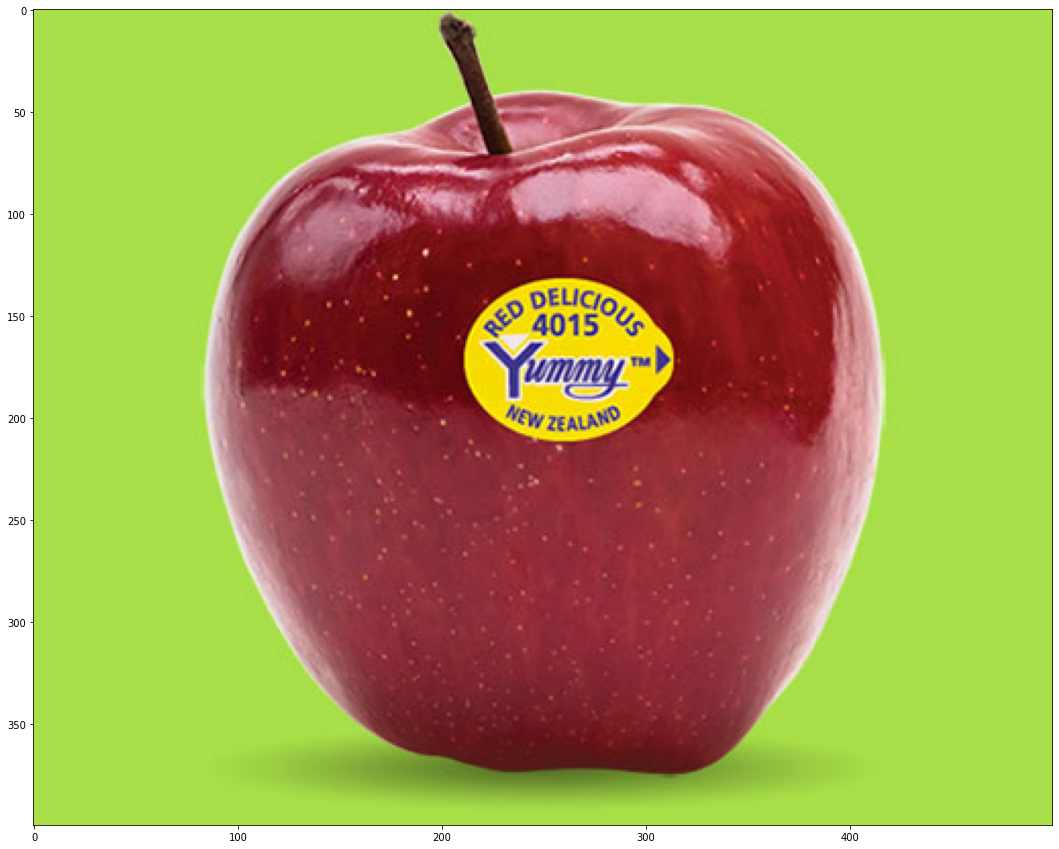

In [26]:
score_threshold = .7
first_out = out[0]
boxes=first_out['boxes'][first_out['scores'] > score_threshold].to('cpu')
labels=['car' for label in (first_out['labels'][first_out['scores'] > score_threshold])]
bounding_boxes_img = draw_bounding_boxes(int_img, boxes, labels=labels, width=8, font_size=15)
plt.figure(figsize=(25, 15))
plt.imshow(bounding_boxes_img.permute(1, 2, 0)) # convert image to matplotlib compatible
plt.show()

Ничего не нашлось :(

 **7). Поиск путей применения этой модели в бизнесе/реальных задачах/набросок встраивания в веб/мобильное демо**
 
В этом пункте нужно подумать, как эта модель может быть использована в дальнейшем. То есть, например, зачем нужно детектировать фрукты? Или одежду?

> Результат пункта $-$ перечисленные кейсы использования модели (описанные **как можно подробнее**).

**IMPORTANT NOTE:** Обычно этим вопросом все же задаются до начала какой-либо разработки. Просто в данном случае проект выполняется скорее в образовательных целях.

Первое, что приходит на ум, это применение детекции фруктов в магазинах.
Подробнее:
В больших супермаркетах часто можно встретить систему, когда покупатель самостоятельно должен взвесить фрукты/овощи.
В данном случае подобные системы позволят упростить поиск нужного товара в интерфейсе весов.

Помимо этого, подобная система, обученная не только на фруктах, но и на товарах в целом, может позволить выстроить антифрод систему на кассах самообслуживания

<h2 style="text-align: center;"><b>Критерии оценивания</b></h2>

* 1 пункт $-$ 1 балл 
* 2 пункт $-$ 1 балл 
* 3 пункт $-$ 0 баллов (промежуточный пункт)  
* 4 пункт $-$ 3 балла   
* 5 пункт $-$ 3 балла   
* 6 пункт $-$ 1 балл 
* 7 пункт $-$ 1 балл 
* Максимум баллов по проекту $-$ 10  

**Успехов в выполнении проекта!** 

Желаю всем проделать полезную, интересную и качественную работу, которую потом нестыдно и в резюме указать, и друзьям показать ;)